In [135]:
import os
import gzip

import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sknetwork.clustering import Louvain
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [25]:
import sys
sys.path.append('/mnt/d/housekeeping_genes')
import housekeepingMinerPy as hkg

# Discovery hkg are based on RNAseq:

- GSE175718 (384)
- GSE120649 (16)
- GSE86884 (96 nr)

## Import DEG from GSE86884 study

In [26]:
path = '/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/hkg/'
lfc_null = 0.5
pv = 0.05
res_files = ['all_factors_lessAbs_0.5_pre_vs_1w_res.csv', 'all_factors_lessAbs_0.5_pre_vs_3m_res.csv', 'all_factors_lessAbs_0.5_pre_vs_6m_res.csv']
res = set()

for i,r in enumerate(res_files):
    aux = pd.read_csv(os.path.join(path,r), index_col=0)
    aux = aux[(aux['log2FoldChange'].abs()<=0.5) & ((aux['padj']<=0.05))]
    if i == 0:
        res = set(aux.index)
    else:
        res = res.intersection(set(aux.index))
print('There are',len(res),'common genes in pre vs 1wk, pre vs 3m and pre vs 6m')

There are 3563 common genes in pre vs 1wk, pre vs 3m and pre vs 6m


## Import RNAseq data for common not DEG

### TPM and Counts

In [27]:
tx2gene = pd.read_csv('/mnt/d/reference_files/homo_sapiens/gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv')

In [28]:
salmon_paths = ['/mnt/d/posttransplant_PRJNA733336_GSE175718/trimmed_salmon_quant/',                
                '/mnt/d/posttransplant_PRJNA493832_GSE120649/trimmed_salmon_quant/',
                '/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/trimmed_salmon_quant/']
tpm = []
counts_tpm = []

for path in salmon_paths:
    tpm_aux = []
    counts_aux = []
    srr_list = os.listdir(path)
    print(path.split('/')[3], end=': ')
    for j,srr in enumerate(srr_list):
        df_aux = pd.read_csv(os.path.join(path,srr,'quant.sf'), sep='\t')[['Name','TPM','EffectiveLength','NumReads']].merge(tx2gene[['Transcript_ID','Gene_name']], left_on='Name', right_on='Transcript_ID')
        df_aux = df_aux.groupby('Gene_name').sum(numeric_only=True)  
        df_aux['counts_tpm'] = np.round(df_aux.NumReads,0).astype(int)
        tpm_aux.append(df_aux.TPM.values)
        counts_aux.append(df_aux.counts_tpm.values)
        print(j, end=' ')
    tpm.append(pd.DataFrame(tpm_aux, columns=df_aux.index, index=srr_list))
    counts_tpm.append(pd.DataFrame(counts_aux, columns=df_aux.index, index=srr_list))
    print('\n')
    # tpm[-1]['Study'] = studies[i]
    
df_tpm = pd.concat(tpm, axis=0)
df_counts = pd.concat(counts_tpm, axis=0)
    # df_tpm#.to_csv('/mnt/d/housekeeping_genes/tpm_blood_pre_pos_pos.csv')

posttransplant_PRJNA733336_GSE175718: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 

In [36]:
adata = ad.AnnData(df_tpm)
adata.layers['count'] = df_counts.loc[adata.obs.index,adata.var.index].values
adata

AnnData object with n_obs × n_vars = 496 × 60883
    layers: 'count'

### Metadata

In [30]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('/mnt/d/postransplant_cristian_colab/metadata/GSE175718_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
            
df_GSE175718_meta = pd.DataFrame(aux).set_index(0).T
df_GSE175718_meta.columns = ['Title', 'Sample Name', 'ar', 'abmrh', 'tcmr', 'polyoma', 'dsa']
df_GSE175718_meta = pd.read_csv('/mnt/d/postransplant_cristian_colab/metadata/SraRunTable.txt')[['Sample Name', 'Run']].merge(df_GSE175718_meta, on='Sample Name').set_index('Sample Name')
df_GSE175718_meta['ar'] = df_GSE175718_meta.ar.str.split(':').str[1].str.strip()
df_GSE175718_meta['abmrh'] = df_GSE175718_meta.abmrh.str.split(':').str[1].str.strip()
df_GSE175718_meta['tcmr'] = df_GSE175718_meta.tcmr.str.split(':').str[1].str.strip()
df_GSE175718_meta['dsa'] = df_GSE175718_meta.dsa.str.split(':').str[1].fillna('0').str.strip()
df_GSE175718_meta['polyoma'] = df_GSE175718_meta.polyoma.str.split(':').str[-1].str.strip()
# no: 0_viremia:1_pvan:2_unknown:3
df_GSE175718_meta['abmrh_tcmr_dsa'] = df_GSE175718_meta[['abmrh', 'tcmr', 'dsa']].agg('-'.join,axis=1)
df_GSE175718_meta[['Title_GC','Title_LN']] = df_GSE175718_meta.Title.str.split('_', expand=True)
df_GSE175718_meta['Title_N'] = df_GSE175718_meta.Title_LN.str[1:]
df_GSE175718_meta['Title_L'] = df_GSE175718_meta.Title_LN.str[0]
df_GSE175718_meta = df_GSE175718_meta.set_index('Run')[['abmrh','tcmr','ar']]
df_GSE175718_meta['gse'] = 'GSE175718'
df_GSE175718_meta['gse_time'] = np.nan
df_GSE175718_meta['gse_patient'] = np.nan

In [31]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('/mnt/d/posttransplant_PRJNA493832_GSE120649/metadata/GSE120649_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
            
df_GSE120649_meta = pd.DataFrame(aux).set_index(0).T.iloc[:,:2]
df_GSE120649_meta.columns = ['Title', 'Sample Name']
df_GSE120649_meta['abmrh'] = np.where(df_GSE120649_meta.Title.str.contains('with antibody mediated rejection'), 1, 0)
df_GSE120649_meta['tcmr'] = np.where(df_GSE120649_meta.Title.str.contains('with T cell mediated rejection'), 1, 0)
df_GSE120649_meta['ar'] = df_GSE120649_meta.abmrh | df_GSE120649_meta.tcmr
df_GSE120649_meta = df_GSE120649_meta.merge(pd.read_csv('/mnt/d/posttransplant_PRJNA493832_GSE120649/metadata/SraRunTable.txt')[['Run','Sample Name']], on='Sample Name')
df_GSE120649_meta = df_GSE120649_meta[df_GSE120649_meta.Run.isin(adata.obs.index)]
df_GSE120649_meta = df_GSE120649_meta.set_index('Run')[['abmrh','tcmr','ar']]
df_GSE120649_meta['gse'] = 'GSE120649'
df_GSE120649_meta['gse_time'] = np.nan
df_GSE120649_meta['gse_patient'] = np.nan

In [32]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/metadata/GSE86884_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
df_GSE86884_meta = pd.DataFrame(aux).set_index(0).T.iloc[:,:2]
df_GSE86884_meta.columns = ['patient','Sample Name']

df_GSE86884_meta = df_GSE86884_meta.merge(pd.read_csv('/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/metadata/SraRunTable.txt')[['Run','time_of_blood_draw','Sample Name']], on='Sample Name').set_index('Run')
condlist = [df_GSE86884_meta.time_of_blood_draw.str.startswith('pre'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('1'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('3'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('6')]
choicelist = ['GSE86884_'+'pre', 'GSE86884_'+'1wk', 'GSE86884_'+'3mo', 'GSE86884_'+'6mo']
df_GSE86884_meta['gse_time'] = np.select(condlist=condlist, choicelist=choicelist)

df_GSE86884_meta['gse'] = 'GSE86884'
df_GSE86884_meta['gse_patient'] = df_GSE86884_meta.patient.str.split('-').str[2]
df_GSE86884_meta['abmrh'] = 0
df_GSE86884_meta['tcmr'] = 0
df_GSE86884_meta['ar'] = 0
df_GSE86884_meta = df_GSE86884_meta.drop(['patient','Sample Name','time_of_blood_draw'], axis=1)

In [33]:
df_GSE175718_meta

,abmrh,tcmr,ar,gse,gse_time,gse_patient
Run,,,,,,
SRR14675811,0,0,0,GSE175718,NaN,NaN
SRR14675812,0,1,1,GSE175718,NaN,NaN
SRR14675813,0,0,0,GSE175718,NaN,NaN
SRR14675814,0,0,0,GSE175718,NaN,NaN
SRR14675815,0,0,0,GSE175718,NaN,NaN
...,...,...,...,...,...,...
SRR14675913,0,1,1,GSE175718,NaN,NaN
SRR14675914,0,1,1,GSE175718,NaN,NaN
SRR14675915,0,1,1,GSE175718,NaN,NaN


In [37]:
adata.obs[['abmrh', 'tcmr', 'ar', 'gse','gse_time','gse_patient']] = pd.concat([df_GSE175718_meta,df_GSE120649_meta,df_GSE86884_meta]).loc[adata.obs.index,:].astype(str).values

In [38]:
adata.var['equivalent'] = np.where(adata.var.index.isin(res), 'equivalent','non_equivalent')

In [39]:
adata

AnnData object with n_obs × n_vars = 496 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient'
    var: 'equivalent'
    layers: 'count'

In [40]:
adata.write_h5ad('/mnt/d/housekeeping_genes/adata_RNAseq.h5ad')

## Read RNAseq adata

In [41]:
adata = ad.read_h5ad('/mnt/d/housekeeping_genes/adata_RNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 496 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient'
    var: 'equivalent'
    layers: 'count'

In [43]:
hkg.pp.create_groups(adata, study_col='gse')

AnnData object with n_obs × n_vars = 496 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

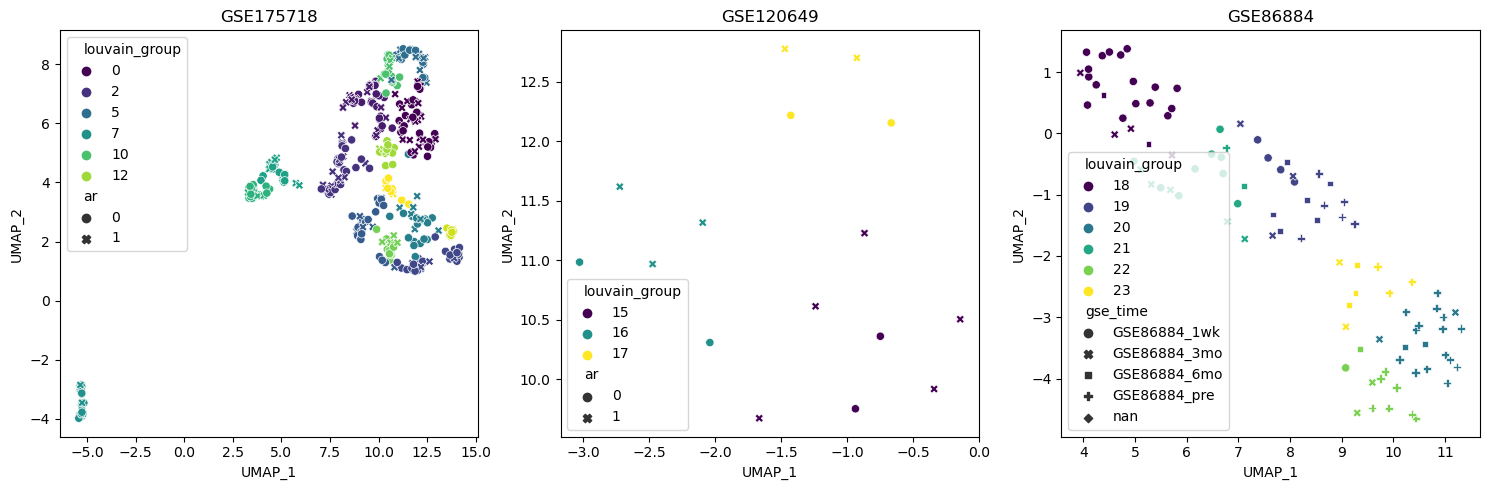

In [63]:
fig = plt.figure(figsize=(15,5))
for i, gse in enumerate(['GSE175718','GSE120649', 'GSE86884']):
    ax = fig.add_subplot(1,3,i+1)
    if gse == 'GSE86884':
        sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='louvain_group', style='gse_time', palette='viridis', data=adata.obs[adata.obs.gse==gse].dropna(), ax=ax)
    else:
        sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='louvain_group', style='ar', palette='viridis', data=adata.obs[adata.obs.gse==gse], ax=ax)
    ax.set_title(gse)
    # ax.legend(ncol=2)
fig.tight_layout()

Since the louvain grouped GSE86884 per time of blood colection, we changed the groups for GSE86884 study by patient group.

In [64]:
adata.obs['louvain_group_updated'] = adata.obs.louvain_group.values
adata.obs.loc[adata.obs.gse=='GSE86884','louvain_group_updated'] = adata.obs.loc[adata.obs.gse=='GSE86884','gse_patient'].values

In [65]:
adata.obs

,abmrh,tcmr,ar,gse,gse_time,gse_patient,louvain_group,UMAP_1,UMAP_2,louvain_group_updated
SRR14675534,1,0,1,GSE175718,nan,nan,0,12.073582,5.214785,0
SRR14675535,0,0,0,GSE175718,nan,nan,11,10.567965,1.372802,11
SRR14675536,0,0,0,GSE175718,nan,nan,8,4.421185,4.588424,8
SRR14675537,0,0,0,GSE175718,nan,nan,3,12.284073,1.281194,3
SRR14675538,0,0,0,GSE175718,nan,nan,4,8.994911,2.404474,4
...,...,...,...,...,...,...,...,...,...,...
SRR4241434,0,0,0,GSE86884,GSE86884_1wk,0180,18,5.710091,0.404293,0180
SRR4241435,0,0,0,GSE86884,GSE86884_pre,0185,20,11.101218,-3.694764,0185
SRR4241436,0,0,0,GSE86884,GSE86884_1wk,0185,18,4.102651,0.921323,0185
SRR4241437,0,0,0,GSE86884,GSE86884_pre,0196,20,10.852351,-2.600498,0196


In [66]:
hkg.pp.log_transform(adata, method='log1p')
hkg.pp.log_transform(adata, method='arcsinh')

AnnData object with n_obs × n_vars = 496 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated'
    var: 'equivalent'
    layers: 'count', 'log1p', 'arcsinh'

In [67]:
adata.obs['type'] = adata.obs.gse.map({'GSE175718':'TMM', 'GSE120649':'TMM', 'GSE86884':'TMM'})

In [71]:
trns_dict = dict(adata.obs[['louvain_group','type']].values)
# print(trns_dict)
hkg.pp.transform_exprs(adata, layer='count', groups_col='louvain_group', trns_dict=trns_dict)

AnnData object with n_obs × n_vars = 496 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated', 'type'
    var: 'equivalent'
    layers: 'count', 'log1p', 'arcsinh', 'trns_expr'

## Keep equivalent genes

In [107]:
adata = adata[:,adata.var.equivalent=='equivalent']
adata

View of AnnData object with n_obs × n_vars = 496 × 3563
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated', 'type'
    var: 'equivalent'
    layers: 'count', 'log1p', 'arcsinh', 'trns_expr'

## Exclude genes with high number of zeros expressions

In [128]:
(aux>0).sum().quantile(.25)

458.0

In [129]:
cols = aux.loc[:,((aux>0).sum()>=450).values].columns.values.tolist()

<Axes: ylabel='Count'>

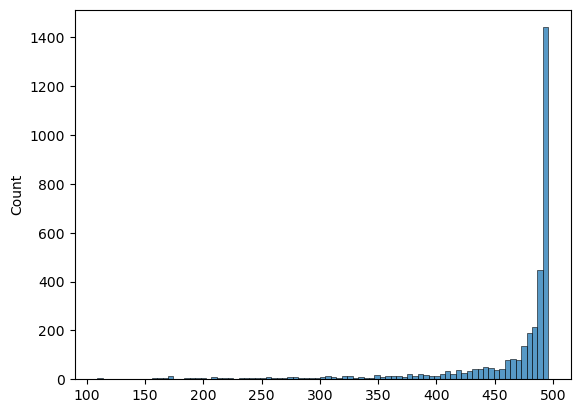

In [130]:
sns.histplot(data=(aux>0).sum())

In [133]:
adata = adata[:,cols]
adata

View of AnnData object with n_obs × n_vars = 496 × 2748
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated', 'type'
    var: 'equivalent'
    layers: 'count', 'log1p', 'arcsinh', 'trns_expr'

## Calculate CV and stb_cv

In [134]:
hkg.mining.exprs_cv(adata, layer='trns_expr', groups_col='louvain_group_updated')
hkg.mining.stability_cv(adata, layer='trns_expr', groups_col='louvain_group_updated')

/mnt/d/housekeeping_genes/housekeepingMinerPy/mining.py:63: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mean_'+str(gc)] = np.mean(X_, axis=0)
/mnt/d/housekeeping_genes/housekeepingMinerPy/mining.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.var['mean_'+str(gc)] = np.mean(X_, axis=0)
/mnt/d/housekeeping_genes/housekeepingMinerPy/mining.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.var['std_'+str(gc)] = np.std(X_, axis=0)
/mnt/d/houseke

Computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 

AnnData object with n_obs × n_vars = 496 × 2748
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated', 'type'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv'
    layers: 'count', 'log1p', 'arcsinh', 'trns_expr'

In [136]:
nearestNeighbors_object = NearestNeighbors()
louvain_object = Louvain(random_state=42, resolution=.5)
scaler_object = StandardScaler()

In [137]:
hkg.mining.uclustering_cv_stb(adata, #cv_col='pool_cv', stb_col='pool_stability_cv',
                              nearestNeighbors_object=nearestNeighbors_object,
                              louvain_object=louvain_object,scaler_object=scaler_object)

AnnData object with n_obs × n_vars = 496 × 2748
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated', 'type'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'uclustering_cv_stb_labels'
    layers: 'count', 'log1p', 'arcsinh', 'trns_expr'

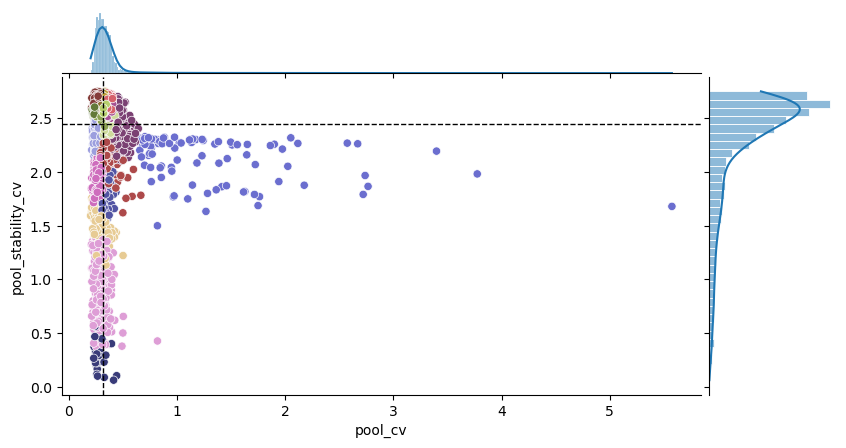

In [138]:
hkg.plot.plot_stb_cv(adata, hue='uclustering_cv_stb_labels', palette='tab20b_r')

In [140]:
adata.var.sort_values('uclustering_cv_stb_labels')

,equivalent,pool_mean,pool_std,pool_cv,pool_stability_cv,uclustering_cv_stb_labels
Gene_name,,,,,,
ZZEF1,equivalent,2967.610776,810.546006,0.273131,1.332917,0
PNISR,equivalent,4126.324244,1164.154073,0.282129,0.522826,0
C6orf62,equivalent,6424.326990,1642.570128,0.255680,0.570443,0
PPIA,equivalent,3376.364075,1431.763164,0.424055,0.619981,0
PPP1R15B,equivalent,3735.355227,863.970337,0.231295,1.098302,0
...,...,...,...,...,...,...
HNRNPC,equivalent,7470.108858,1844.825854,0.246961,0.326360,18
SRRM2,equivalent,13652.996189,4439.879652,0.325195,0.231551,18
PRRC2C,equivalent,8229.211543,2266.116434,0.275375,0.291907,18


In [141]:
adata.var[adata.var.uclustering_cv_stb_labels==0]

,equivalent,pool_mean,pool_std,pool_cv,pool_stability_cv,uclustering_cv_stb_labels
Gene_name,,,,,,
ACIN1,equivalent,3186.571273,766.074743,0.240407,1.018354,0
ADCY7,equivalent,4591.320367,1463.437920,0.318740,1.155244,0
ADD1,equivalent,3818.694902,854.746209,0.223832,0.801748,0
ADD3,equivalent,6492.837587,1682.560599,0.259141,0.469192,0
AGO2,equivalent,2934.861743,950.655072,0.323918,0.941609,0
...,...,...,...,...,...,...
ZNF24,equivalent,3261.731461,742.994022,0.227791,0.912261,0
ZNF33A,equivalent,2808.625136,784.048468,0.279157,1.171027,0
ZNF638,equivalent,2603.531491,576.407496,0.221394,1.314143,0


In [142]:
adata_hkg = adata[:,adata.var.uclustering_cv_stb_labels==0]

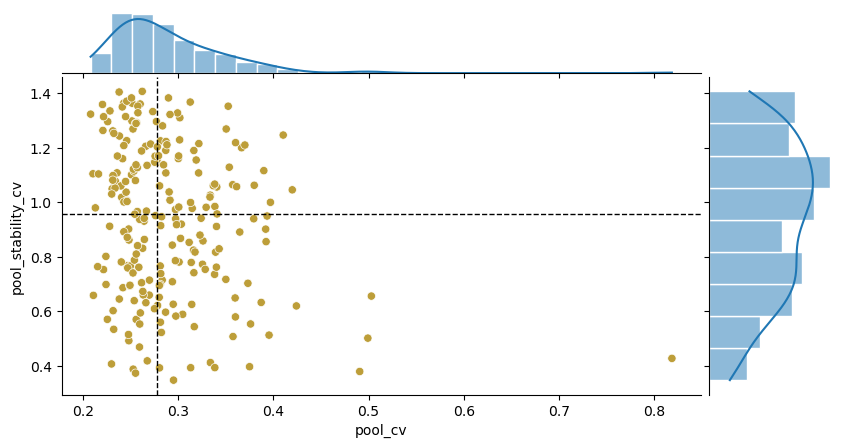

In [153]:
hkg.plot.plot_stb_cv(adata_hkg, hue='uclustering_cv_stb_labels', palette='tab20b_r')

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


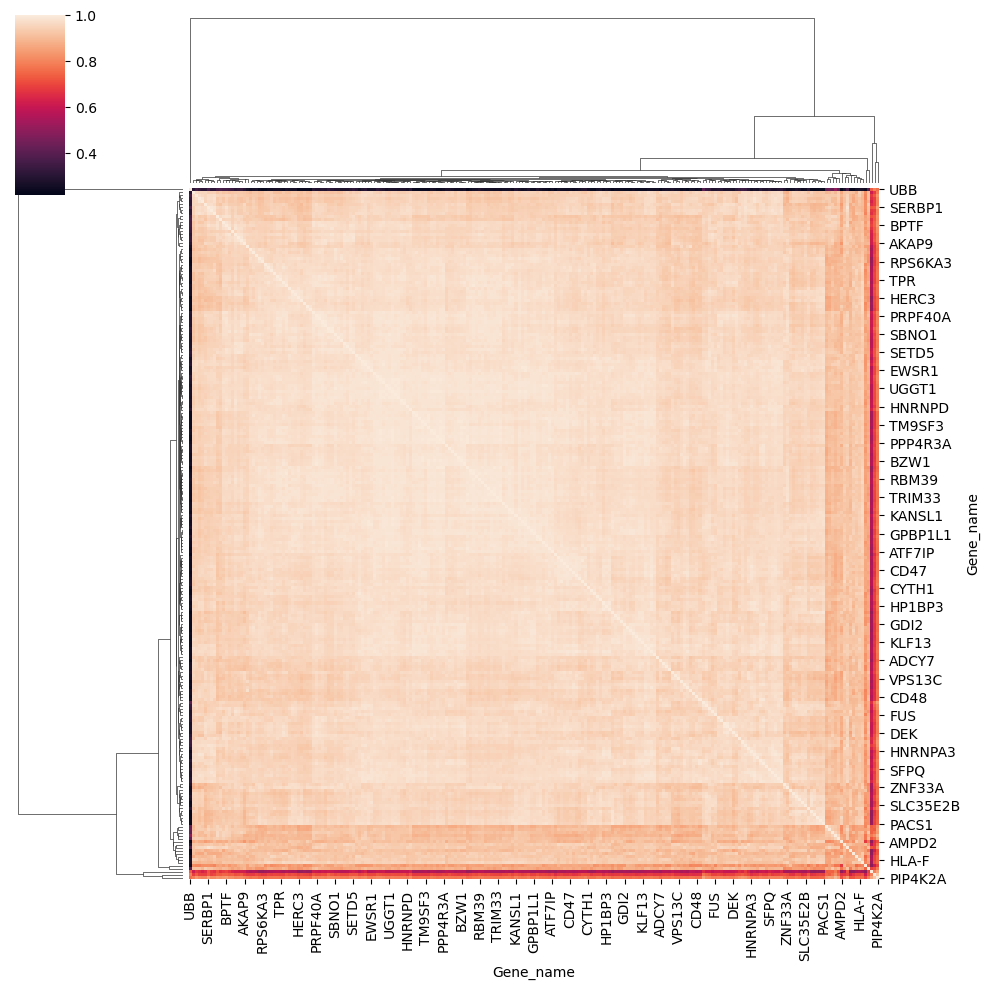

In [152]:
sns.clustermap(adata_hkg.to_df('trns_expr').corr())

In [143]:
ga_res = hkg.mining.hkg_selection_ga(adata_hkg, layer='trns_expr', fitness_function='minimize_outliers')
ga_res

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


(array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1]),
 448,
 0)

In [144]:
adata_hkg[:,np.where(ga_res[0])[0]].var

,equivalent,pool_mean,pool_std,pool_cv,pool_stability_cv,uclustering_cv_stb_labels
Gene_name,,,,,,
ACIN1,equivalent,3186.571273,766.074743,0.240407,1.018354,0
ADCY7,equivalent,4591.320367,1463.437920,0.318740,1.155244,0
ADD1,equivalent,3818.694902,854.746209,0.223832,0.801748,0
ADD3,equivalent,6492.837587,1682.560599,0.259141,0.469192,0
AMPD2,equivalent,3264.405405,1154.021615,0.353517,1.128882,0
...,...,...,...,...,...,...
XIAP,equivalent,2415.016111,590.628360,0.244565,1.076559,0
YTHDC1,equivalent,2260.342950,577.611922,0.255542,1.289374,0
ZNF207,equivalent,4009.054497,998.805660,0.249137,0.695792,0


In [146]:
adata_hkg2 = adata_hkg[:,np.where(ga_res[0])[0]]
adata_hkg2

View of AnnData object with n_obs × n_vars = 496 × 111
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated', 'type'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'uclustering_cv_stb_labels'
    layers: 'count', 'log1p', 'arcsinh', 'trns_expr'

In [147]:
ga_res2 = hkg.mining.hkg_selection_ga(adata_hkg2, layer='trns_expr', fitness_function='minimize_outliers')
ga_res2

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


(array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1]),
 447,
 0)

In [148]:
adata_hkg2[:,np.where(ga_res2[0])[0]].var

,equivalent,pool_mean,pool_std,pool_cv,pool_stability_cv,uclustering_cv_stb_labels
Gene_name,,,,,,
AMPD2,equivalent,3264.405405,1154.021615,0.353517,1.128882,0
ARF6,equivalent,2944.162456,887.853991,0.301564,1.310285,0
ARGLU1,equivalent,3507.528538,1109.474926,0.316312,0.741810,0
ARHGEF1,equivalent,6156.665984,1527.369617,0.248084,0.861809,0
BRD2,equivalent,4625.108010,1246.135348,0.269428,0.659689,0
C16orf54,equivalent,3885.501251,962.796919,0.247792,0.902143,0
C6orf62,equivalent,6424.326990,1642.570128,0.255680,0.570443,0
CDC42SE2,equivalent,6391.038947,1620.827112,0.253609,0.639264,0
CGGBP1,equivalent,3242.011650,786.493145,0.242594,1.363814,0


In [89]:
tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().Gene_type.unique()

array(['rRNA', 'misc_RNA', 'protein_coding', 'lncRNA', 'scRNA', 'TEC',
       'snoRNA', 'miRNA', 'ribozyme', 'scaRNA', 'artifact', 'sRNA',
       'snRNA', 'IG_V_gene', 'TR_V_gene', 'TR_D_gene', 'IG_C_gene',
       'IG_D_gene', 'IG_J_gene', 'Mt_rRNA', 'Mt_tRNA', 'TR_C_gene',
       'TR_J_gene', 'vault_RNA'], dtype=object)

In [95]:
a = tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().duplicated(subset=['Gene_name'], )

In [99]:
tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().loc[a].Gene_name.values

array(['ARMCX5-GPRASP2', 'ELFN2', 'GOLGA8M', 'KBTBD11-OT1', 'LINC02203',
       'SFTA3', 'SIGLEC5', 'SPATA13'], dtype=object)

In [103]:
tx2gene[tx2gene.Gene_name.isin(tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().loc[a].Gene_name.values)].sort_values('Gene_type')

,Transcript_ID,Gene_name,Gene_ID,Gene_type,Gene_lenght,Transcript_Name
167909,ENST00000418548.3,SFTA3,ENSG00000229415.10,lncRNA,36787,SFTA3-201
174624,ENST00000643304.1,LINC02203,ENSG00000284988.1,lncRNA,4347,LINC02203-205
226923,ENST00000534261.4,SIGLEC5,ENSG00000105501.13,lncRNA,15445,SIGLEC5-201
241655,ENST00000430883.5,ELFN2,ENSG00000243902.6,lncRNA,45701,ELFN2-207
167910,ENST00000521380.1,SFTA3,ENSG00000229415.10,lncRNA,610,SFTA3-208
248722,ENST00000671383.1,ARMCX5-GPRASP2,ENSG00000271147.8,lncRNA,12319,ARMCX5-GPRASP2-210
167908,ENST00000518446.1,SFTA3,ENSG00000229415.10,lncRNA,39027,SFTA3-203
167907,ENST00000524122.5,SFTA3,ENSG00000229415.10,lncRNA,38524,SFTA3-209
167906,ENST00000518987.5,SFTA3,ENSG00000229415.10,lncRNA,38829,SFTA3-205
167905,ENST00000521114.5,SFTA3,ENSG00000229415.10,lncRNA,39830,SFTA3-207


In [85]:
tx2gene[['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().pivot(index='Gene_name', columns='Gene_type', values='Gene_lenght')

,Gene_name,Gene_type,Gene_lenght
0,5S_rRNA,rRNA,101.000000
1,5S_rRNA,rRNA_pseudogene,119.666667
2,5_8S_rRNA,rRNA,151.833333
3,7SK,misc_RNA,267.142857
4,A1BG,protein_coding,4147.000000
...,...,...,...
61473,ZZZ3,protein_coding,52819.909091
61474,hsa-mir-1253,lncRNA,105.000000
61475,hsa-mir-423,lncRNA,94.000000
61476,hsa-mir-8069-1,miRNA,86.000000


In [3]:
adata = ad.read_h5ad('/mnt/d/postransplant_cristian_colab/predictor/adata_ALLgenes_ngs_ma_predictor_dataset.h5ad')
adata

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2'
    layers: 'arcsinh'

In [4]:
adata.obs.gse.unique()

['GSE175718', 'GSE120649', 'GSE14346', 'GSE15296', 'GSE129166', 'GSE46474']
Categories (6, object): ['GSE14346', 'GSE15296', 'GSE46474', 'GSE120649', 'GSE129166', 'GSE175718']

In [5]:
hkg.pp.log_transform(adata, method='log1p')
hkg.pp.log_transform(adata, method='arcsinh')

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2'
    layers: 'arcsinh', 'log1p'

In [6]:
# adata.obs['type'] = adata.obs.gse.map({'GSE175718':'TMM', 'GSE120649':'TMM', 'GSE14346':'quantile', 'GSE15296':'quantile', 'GSE129166':'quantile', 'GSE46474':'quantile'})
adata.obs['type'] = adata.obs.gse.map({'GSE175718':'TMM4', 'GSE120649':'TMM4', 'GSE14346':'quantile', 'GSE15296':'quantile', 'GSE129166':'quantile', 'GSE46474':'quantile'})

adata

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p'

In [7]:
trns_dict = dict(adata.obs[['louvain_group','type']].values)
print(trns_dict)
hkg.pp.transform_exprs(adata, groups_col='louvain_group', trns_dict=trns_dict)

{8: 'TMM4', 2: 'TMM4', 7: 'TMM4', 3: 'TMM4', 5: 'TMM4', 9: 'TMM4', 6: 'TMM4', 4: 'TMM4', 1: 'TMM4', 0: 'TMM4', 19: 'quantile', 20: 'quantile', 21: 'quantile', 22: 'quantile', 23: 'quantile', 24: 'quantile', 10: 'quantile', 14: 'quantile', 17: 'quantile', 13: 'quantile', 11: 'quantile', 15: 'quantile', 16: 'quantile', 12: 'quantile', 18: 'quantile', 26: 'quantile', 25: 'quantile'}


/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict value for the group8 is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['8 = TMM4
  warnings.warn("The trns_dict value for the group" + str(gc) + " is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['"+str(gc)+" = "+str(trns_dict[gc]))
/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict value for the group2 is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['2 = TMM4
  warnings.warn("The trns_dict value for the group" + str(gc) + " is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['"+str(gc)+" = "+str(trns_dict[gc]))
/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict 

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p', 'trns_expr'

# Exclude genes with high number of zeros expressions

In [8]:
aux = adata.to_df()

<Axes: ylabel='Count'>

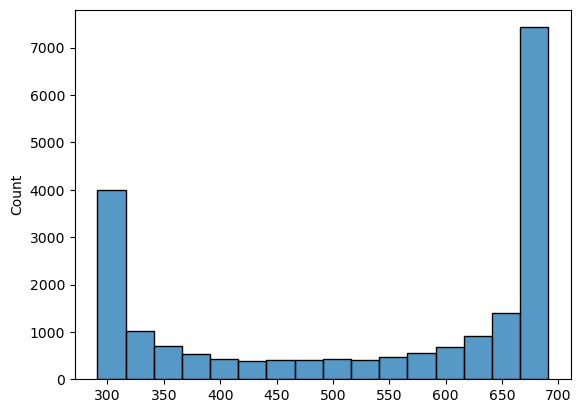

In [9]:
sns.histplot(data=(aux>0).sum())

In [10]:
aux = adata.to_df()
th = (aux>0).sum().quantile(.7)
print(th)
# cols = aux.loc[:,(((aux>0).sum())>=th).values].columns
cols = aux.loc[:,(((aux>0).sum())>=th).values].columns
aux.loc[:,(((aux>0).sum())>=th).values].head()

679.0


,NMNAT3,NMT1,LPCAT1,KRT23,EVL,MACF1,PRPF19,NEK7,APOL1,PHKG2,...,CCT5,PURA,HLA-DRB1,NLRC5,SERINC3,PHACTR1,SLC7A14,CTDSP2,NCOA2,PDE4B
SRR14675811,3.698268,17.869562,1.247063,3.279311,13.157526,9.208133,1.969213,1.385902,3.378063,0.800857,...,5.351533,8.111878,35.055475,9.766339,4.818316,1.233866,0.574693,3.515069,3.136384,9.050980
SRR14675812,1.216780,4.714020,0.113627,0.741127,3.365281,9.412744,0.050293,0.565136,1.491737,0.204446,...,0.517397,2.926578,4.955858,2.845137,1.313767,1.675404,0.276092,1.226684,0.853023,2.809990
SRR14675813,8.288824,33.533007,0.787019,3.762472,23.296083,8.160651,1.672085,1.956752,5.025311,2.414696,...,6.689530,9.742505,93.873232,20.077701,6.593228,1.376828,0.752742,7.310164,2.464601,32.181997
SRR14675814,3.256562,16.929764,1.062071,4.919020,14.073394,7.278472,1.631437,0.640845,4.142695,1.145673,...,5.449680,9.510379,45.416548,9.583654,3.362681,3.833964,0.252629,3.344405,0.898820,6.214739
SRR14675815,2.328703,17.900022,1.724819,1.685062,11.383978,4.592463,0.717625,0.863289,2.081147,0.685227,...,3.552950,5.824697,12.197730,9.291400,3.087440,1.910687,0.174879,2.491886,0.949243,4.179272


In [11]:
adata = adata[:,cols]
adata

View of AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [12]:
hkg.mining.exprs_cv(adata, layer='trns_expr', groups_col='louvain_group')
hkg.mining.stability_cv(adata, layer='trns_expr', groups_col='louvain_group')

/mnt/d/housekeeping_genes/housekeepingMinerPy/mining.py:63: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mean_'+str(gc)] = np.mean(X_, axis=0)


AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [13]:
hkg.mining.stability_cv(adata, layer='trns_expr', groups_col='louvain_group')

Computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [14]:
from sklearn.neighbors import NearestNeighbors
from sknetwork.clustering import Louvain
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [15]:
nearestNeighbors_object = NearestNeighbors()
louvain_object = Louvain(random_state=42, resolution=.5)
scaler_object = StandardScaler()

In [16]:
hkg.mining.uclustering_cv_stb(adata, #cv_col='pool_cv', stb_col='pool_stability_cv',
                              nearestNeighbors_object=nearestNeighbors_object,
                              louvain_object=louvain_object,scaler_object=scaler_object)

AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [17]:
adata.var.uclustering_cv_stb_labels.nunique()

35

In [18]:
# ax = sns.scatterplot(x='pool_cv',y='pool_stability_cv', hue='uclustering_cv_stb_labels', palette='tab20b', data=adata.var, legend=False)

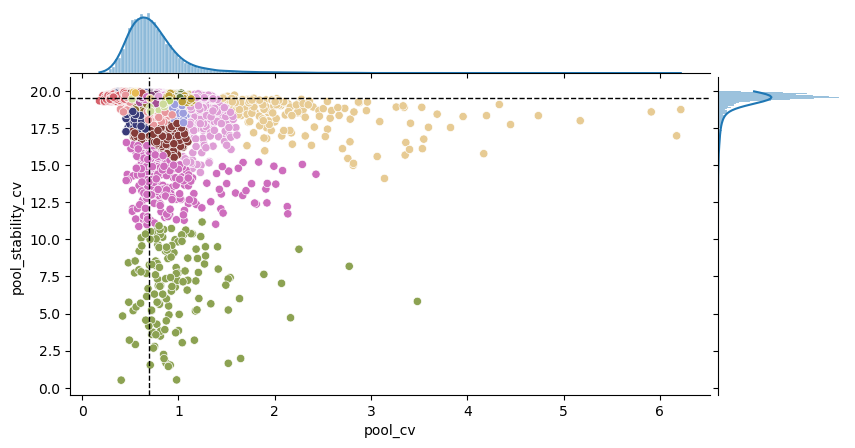

In [19]:
hkg.plot.plot_stb_cv(adata, hue='uclustering_cv_stb_labels', palette='tab20b_r')

In [20]:
adata.var.sort_values('pool_stability_cv')

,pool_mean,pool_std,pool_cv,pool_stability_cv,uclustering_cv_stb_labels
HBB,99764.077436,40419.936530,0.405155,0.503488,24
HBA1,14823.905991,14542.339640,0.981006,0.520577,24
MALAT1,786.572484,704.052900,0.895090,1.427392,24
IFITM2,1579.634733,1444.690153,0.914572,1.519526,24
RPLP2,489.008518,345.754933,0.707053,1.524594,24
...,...,...,...,...,...
ACOT9,1.785973,0.784523,0.439269,19.980790,10
TIMMDC1,1.582027,0.708692,0.447965,19.984469,10
NDUFS2,1.649627,0.663905,0.402457,19.987955,10
DPF2,1.658645,0.836746,0.504475,19.988540,12


In [21]:
adata.var[adata.var.uclustering_cv_stb_labels==24]

,pool_mean,pool_std,pool_cv,pool_stability_cv,uclustering_cv_stb_labels
RPS25,40.598777,37.645776,0.927264,9.155098,24
RPL6,31.695004,26.157060,0.825274,10.633936,24
ARPC2,33.075568,22.007836,0.665380,10.253461,24
STAG2,108.974040,178.118465,1.634504,6.006582,24
RPL23A,69.227685,54.701611,0.790170,6.877257,24
...,...,...,...,...,...
EEF1A1,94.008763,115.786511,1.231657,10.196096,24
RPS23,43.801536,48.048271,1.096954,8.739622,24
IRF1,63.640929,51.369607,0.807179,6.837682,24
FTL,188.086199,92.195835,0.490179,3.204947,24


In [22]:
adata_hkg = adata[:,adata.var.uclustering_cv_stb_labels==24]

In [25]:
adata_hkg = adata[:,adata.var.uclustering_cv_stb_labels==24]
ga_res = hkg.mining.hkg_selection_ga(adata_hkg, layer='trns_expr', fitness_function='minimize_outliers')
adata_hkg[:,np.where(ga_res2[0])[0]].var

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [29]:
np.where(ga_res[0])

(array([  0,   2,   3,   5,   8,   9,  11,  12,  13,  14,  17,  20,  22,
         24,  27,  28,  31,  35,  36,  41,  42,  43,  47,  49,  50,  51,
         52,  55,  57,  61,  64,  65,  67,  72,  76,  77,  78,  80,  81,
         82,  83,  84,  85,  86,  88,  89,  91,  93,  98,  99, 100, 102,
        104, 105, 109, 111, 112, 115, 118, 121, 122, 124, 127, 129, 131,
        132, 133, 134, 135, 138, 144, 145]),)

In [37]:
# adata_hkg = adata_hkg[:,np.where(ga_res[0])[0]]

In [39]:
ga_res2 = hkg.mining.hkg_selection_ga(adata_hkg, layer='trns_expr', fitness_function='minimize_outliers')

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [40]:
np.where(ga_res2[0])

(array([ 0,  3,  4,  6,  7, 11, 12, 14, 17, 20, 30, 31, 32, 33, 35, 36, 38,
        40, 42, 43, 46, 48, 53, 56, 58, 59, 64, 65, 69]),)

In [42]:
adata_hkg[:,np.where(ga_res2[0])[0]].var

,pool_mean,pool_std,pool_cv,pool_stability_cv,uclustering_cv_stb_labels
RPS25,40.598777,37.645776,0.927264,9.155098,24
CTSS,53.398740,41.127924,0.770204,8.507482,24
S100A12,48.898648,101.242902,2.070464,7.039054,24
TPT1,98.109230,98.878245,1.007838,4.944391,24
OAZ1,107.616005,45.203602,0.420045,4.832231,24
RPL37,47.667149,47.442386,0.995285,7.736307,24
SELL,32.806433,22.674658,0.691165,10.493856,24
MYL6,41.171375,24.360889,0.591695,9.214063,24
RPL30,151.848911,147.455281,0.971066,3.701300,24
S100A9,488.085639,424.770455,0.870279,1.663387,24


In [25]:
np.__version__

'1.26.3'

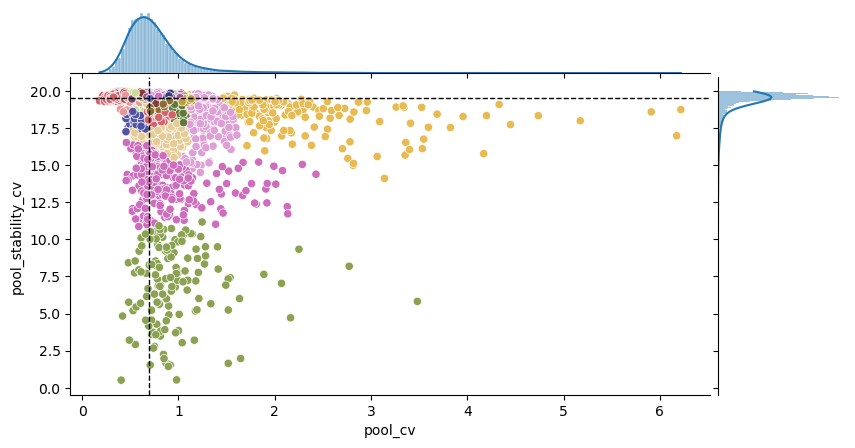

In [25]:
hkg.plot.plot_stb_cv(adata, x='pool_cv', y='pool_stability_cv', hue='uclustering_cv_stb_labels', palette='tab20b_r')

AttributeError: 'DataFrame' object has no attribute 'uclustering_cv_stb_labels'

In [25]:
import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

def plot_stb_cv(adata, x:str = 'pool_cv', y:str = 'pool_stability_cv', hue:str = 'uclustering_cv_stb_labels'):
    fig = plt.figure(figsize=(8.35,8.35))
    gs = GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], wspace=.02, hspace=.02)

    ax_clu = fig.add_subplot(gs[1,0])
    ax_hist_cv = fig.add_subplot(gs[1,1])
    ax_hist_mean = fig.add_subplot(gs[0,0])

    sns.scatterplot(x=x, y=y, hue=hue, palette=None, data=adata.var, s=60, ax=ax_clu)
    ax_clu.spines[['right', 'top']].set_visible(False)

    sns.histplot(x=x, ec='white', data=adata.var, kde=True, ax=ax_hist_mean)
    ax_hist_mean.spines[['left','right', 'top']].set_visible(False)
    ax_hist_mean.set_xlabel(None)
    ax_hist_mean.set_ylabel(None)
    ax_hist_mean.set_xticklabels([])
    ax_hist_mean.set_yticklabels([])
    ax_hist_mean.tick_params(left = False)
    ax_hist_mean.grid(False)

    sns.histplot(y=y, ec='white', data=adata.var, kde=True, ax=ax_hist_cv)
    ax_hist_cv.spines[['right', 'top','bottom']].set_visible(False)
    ax_hist_cv.set_ylabel(None)
    ax_hist_cv.set_xlabel(None)
    ax_hist_cv.set_yticklabels([])
    ax_hist_cv.set_xticklabels([])
    ax_hist_cv.tick_params(bottom = False)
    ax_hist_cv.grid(False)

    # return fig

TypeError: plot_stb_cv() got an unexpected keyword argument 'palette'

In [27]:
import tempfile
import itertools
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances

In [38]:
adata = adata[:, :5]

In [138]:
cols_ = []
idx_ = []
groups_col = 'louvain_group'
X_ = adata.layers['trns_expr']
df_mean_ = []
df_std_ = []
j = 0
groups = adata.obs[groups_col].unique()
for i,gc in enumerate(groups):
    print(i, end=' ')
    idx = np.where(adata.obs[groups_col]==gc)
    df_mean_.append( pairwise_distances(X_[idx,:][0].T).mean(axis=0) )
    df_std_.append( pairwise_distances(X_[idx,:][0].T).std(axis=0) )
    # .append(mean_X_)
    # .append(std_X_)
# aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
# del(df_std_)
# del(df_mean_)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [149]:
pairwise_distances(X_[:,:].T).std(axis=0) / pairwise_distances(X_[:,:].T).mean(axis=0)

array([31.80105014, 31.51076177, 31.98414822, ..., 32.01317731,
       32.13324751, 32.09113263])

In [174]:
aux = pd.DataFrame(np.array(df_std_) / np.array(df_mean_)).T
aux.columns = ['gc_'+str(g) for g in groups]
aux

,gc_8,gc_2,gc_7,gc_3,gc_5,gc_9,gc_6,gc_4,gc_1,gc_0,...,gc_14,gc_17,gc_13,gc_11,gc_15,gc_16,gc_12,gc_18,gc_26,gc_25
0,33.712148,37.854610,30.344044,33.927517,34.428704,31.265417,36.846921,32.834539,34.129976,25.735936,...,0.537394,0.566831,0.752540,0.607329,0.549425,0.588862,0.626404,0.614936,0.533541,0.634044
1,33.884421,37.966903,29.862405,33.813666,34.674488,31.211331,37.096299,32.805951,31.659862,20.140710,...,1.077456,1.047807,1.099893,1.103388,1.024392,1.069875,1.083297,1.069468,1.015483,0.993912
2,33.943080,38.098223,30.975092,34.304407,35.003174,31.282843,37.224410,33.802238,33.421917,23.170773,...,0.708590,0.787005,0.569519,0.744603,0.704903,0.628132,0.715949,0.738218,0.623473,0.679039
3,33.536398,37.812253,30.179171,33.489584,34.597237,31.270713,37.001334,33.410994,34.328347,26.230049,...,0.332160,0.376877,0.296770,0.315294,0.300599,0.293204,0.307696,0.352859,0.310655,0.297306
4,33.755481,38.027778,30.711519,34.140146,34.810167,31.167430,37.107628,33.562803,34.470864,26.436957,...,0.881399,0.782858,0.778564,0.884723,0.820884,0.781399,0.817679,0.859213,0.575551,0.626958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,33.851090,38.058819,30.822194,34.314018,34.649977,31.294309,37.162580,33.338767,33.809245,25.146018,...,0.437228,0.549896,0.351828,0.400803,0.423638,0.418765,0.355791,0.465915,0.359092,0.338844
2125,32.573522,37.474768,28.254035,32.617580,33.692795,31.109704,36.106875,31.577571,31.319904,19.632275,...,1.015007,0.961417,1.012342,1.018804,0.978202,0.987881,1.015146,0.981714,1.010361,1.005151
2126,33.865384,38.082253,30.832617,34.297910,34.910746,31.279061,37.189708,33.699908,33.716253,23.820033,...,1.094967,1.042664,1.094336,1.111421,1.050594,1.067086,1.094451,1.046086,1.075890,1.064157
2127,33.888833,38.082066,30.963397,34.233472,34.926460,31.271717,37.235983,33.690716,34.498268,26.484824,...,1.124372,1.074739,1.113702,1.131445,1.089499,1.091813,1.126486,1.091035,1.064130,1.066080


In [166]:
(pd.DataFrame(df_std_) / pd.DataFrame(df_mean_))#.mean(axis=0).sort_values()

,0,1,2,3,4,5,6,7,8,9,...,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128
0,33.712148,33.884421,33.943080,33.536398,33.755481,33.856560,32.912147,33.654800,33.871838,33.805705,...,29.574178,33.757345,33.820386,33.764483,23.989367,33.851090,32.573522,33.865384,33.888833,33.758087
1,37.854610,37.966903,38.098223,37.812253,38.027778,38.075624,37.338808,37.902503,38.077872,38.075637,...,36.500088,38.030298,38.059610,38.048886,34.537898,38.058819,37.474768,38.082253,38.082066,38.047201
2,30.344044,29.862405,30.975092,30.179171,30.711519,30.912682,29.177947,30.258487,30.960445,30.975212,...,24.393286,30.810543,30.817761,30.829915,21.322306,30.822194,28.254035,30.832617,30.963397,30.840261
3,33.927517,33.813666,34.304407,33.489584,34.140146,34.200432,32.895037,33.970324,34.259007,34.270961,...,29.586378,34.128269,34.139334,34.120706,26.378003,34.314018,32.617580,34.297910,34.233472,34.220636
4,34.428704,34.674488,35.003174,34.597237,34.810167,34.906617,33.371481,34.734824,34.937590,34.956476,...,32.330504,34.811497,34.895957,34.863682,30.048254,34.649977,33.692795,34.910746,34.926460,34.713433
5,31.265417,31.211331,31.282843,31.270713,31.167430,31.280226,30.951243,31.276802,31.285305,31.267506,...,31.171255,31.279277,31.292487,31.292291,30.925393,31.294309,31.109704,31.279061,31.271717,31.287808
6,36.846921,37.096299,37.224410,37.001334,37.107628,37.218402,36.706198,36.799265,37.176202,37.193032,...,33.292034,37.132185,37.161763,37.141170,31.365057,37.162580,36.106875,37.189708,37.235983,37.156504
7,32.834539,32.805951,33.802238,33.410994,33.562803,33.694867,31.278340,33.535953,33.750341,33.765025,...,30.339102,33.565650,33.675126,33.646798,27.826684,33.338767,31.577571,33.699908,33.690716,33.720693
8,34.129976,31.659862,33.421917,34.328347,34.470864,34.156661,34.414874,34.336676,34.435473,34.031543,...,33.973682,34.438171,33.711610,34.480771,33.311946,33.809245,31.319904,33.716253,34.498268,34.451313
9,25.735936,20.140710,23.170773,26.230049,26.436957,25.869226,26.324253,25.945176,26.347265,25.586754,...,24.874632,26.435539,24.988275,26.289497,24.654756,25.146018,19.632275,23.820033,26.484824,26.427916


In [58]:
cols_ = []
idx_ = []
groups_col = 'louvain_group'
X_ = adata.layers['trns_expr']
df_mean_ = []
df_std_ = []
j = 0
groups = adata.obs[groups_col].unique()
for k,gc in enumerate(groups):
    print(k, end=' ')
    idx = np.where(adata.obs[groups_col]==gc)
    mean_X_ = []
    std_X_ = []
    for i in range(X_.shape[1]):
        mean_X_.extend(np.mean(X_[idx,i:] - X_[idx,i,None], axis=1)[0].astype(str))
        std_X_.extend(np.std(X_[idx,i:] - X_[idx,i,None], axis=1)[0].astype(str))
        if j == 0:            
            cols_.extend([','.join(p) for p in itertools.product([adata.var.index[i]],adata.var[i:].index)])                
    j+=1

    if k == 0:
        with open('/mnt/d/housekeeping_genes/test_stb_mean.csv', 'w') as f:
            f.write('\t'.join(cols_)+'\n')
    with open('/mnt/d/housekeeping_genes/test_stb_mean.csv', 'a') as f:
        f.write('\t'.join(mean_X_)+'\n')
#     df_mean_.append(mean_X_)
#     df_std_.append(std_X_)
# aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
# del(df_std_)
# del(df_mean_)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [100]:
X_ = adata.layers['trns_expr']

In [108]:
pairwise_distances(X_.T).mean(axis=0)

array([6079.36114954, 6135.31541746, 6044.7064307 , ..., 6039.21480393,
       6016.74664974, 6024.5745967 ])

In [110]:
pairwise_distances(X_.T).std(axis=0)

array([193330.06873945, 193328.46250872, 193334.78642725, ...,
       193334.45436032, 193337.6092993 , 193335.42242762])

In [98]:
X_[:,0] - X_[:,1]

array([ -1, -11])

In [19]:
aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
aux = aux[[c for c in aux.columns if (len(set(c.split(',')))>1)]].abs()
aux = aux.mean(axis=0).reset_index()
aux.columns = ['gene', 'stability_cv']
aux[['G1','G2']] = aux['gene'].str.split(',', expand=True)
aux = pd.concat([aux[['G1','stability_cv']].set_index('G1'), aux[['G2','stability_cv']].set_index('G2')], axis=0).reset_index()
aux.columns = ['gene', 'stability_cv']
# adata.var['pool_stability_cv'] = aux.groupby('gene').mean().loc[adata.var.index,:]
aux

,gene,stability_cv
0,TPT1,0.386237
1,TPT1,0.365534
2,TPT1,0.689933
3,TPT1,0.459710
4,TPT1,0.484252
...,...,...
235,TRIM13,0.324191
236,SYNE3,0.231898
237,TRIM13,0.441273
238,SYNE3,0.380119


In [140]:
adata.var

,pool_mean,pool_std,pool_cv,pool_stability_cv
TPT1,99.870647,101.984256,1.021163,1.281687
STIP1,1.542766,0.726204,0.470715,1.118414
SCFD1,4.743274,2.149083,0.453080,2.230019
RPL37,47.793400,45.747994,0.957203,4.606917
OGA,6.913984,4.028201,0.582616,1.373671
SAMHD1,5.647720,3.479893,0.616159,0.836379
SLC25A37,206.447476,186.235511,0.902096,0.714871
RYBP,4.081056,2.947615,0.722268,1.262018
SPECC1,4.439930,3.895261,0.877325,1.179602
EPB41,13.324056,15.192647,1.140242,1.627686


In [103]:
adata[adata.obs.gse=='GSE120649',:].X

ArrayView([[9.98638170e+01, 2.06423100e+00, 3.80511600e+00,
            3.58792590e+01, 1.47395240e+01, 1.29085990e+01,
            3.90202832e+02, 1.43453200e+00, 1.21606710e+01,
            4.95345740e+01, 4.35112400e+00, 1.21213804e+05,
            4.68641160e+01, 1.57683926e+04, 7.74075000e-01,
            1.62781200e+00],
           [2.92362182e+02, 8.01974800e+00, 1.51823210e+01,
            1.11205999e+02, 4.37109740e+01, 4.69621330e+01,
            3.72636744e+02, 4.37952400e+00, 2.06417450e+01,
            6.12572010e+01, 1.51558080e+01, 1.17208240e+05,
            1.15346969e+02, 1.44692470e+04, 3.34425000e+00,
            5.09943500e+00],
           [8.72300815e+02, 7.26774800e+00, 1.84634900e+01,
            4.17397507e+02, 5.62469270e+01, 4.40823270e+01,
            2.58591105e+02, 5.73111700e+00, 1.53003950e+01,
            5.94940740e+01, 2.20880010e+01, 9.18616368e+04,
            1.23745731e+02, 8.47847636e+03, 6.19110400e+00,
            5.22581100e+00],
           [4

In [102]:
adata.obs.gse.unique()

['GSE175718', 'GSE120649', 'GSE14346', 'GSE15296', 'GSE129166', 'GSE46474']
Categories (6, object): ['GSE14346', 'GSE15296', 'GSE46474', 'GSE120649', 'GSE129166', 'GSE175718']

In [90]:
np.mean(X_[idx,i:] - X_[idx,i,None], axis=1).shape

(1, 2129)

In [94]:
np.mean(X_[idx,129:] - X_[idx,129,None], axis=1)[0]

array([ 0.        , -0.09190557, -0.60799553, ...,  0.00485014,
        0.01155771, -0.41119867])

In [96]:
len(mean_X_)

57483

In [1]:
# df_temp = pd.read_csv(temp.name)
# df_temp
temp.close()

NameError: name 'temp' is not defined

In [36]:
df_temp

NameError: name 'df_temp' is not defined

In [20]:
# 